# Quantum Algorithm for Solving the Poisson Equation

The Poisson equation is a partial differential equation that appears in various research fields, such as physics and engineering. It describes the distribution of a potential field, $u$, under some source term $b$:
$$
\nabla^2 u = b,
$$
where the $\nabla^2$ is the Laplacian (second derivatives) operator. One approach for numerically solving the Poisson equation is to move from the continuous description to a discrete one, using the finite difference method that casts the problem into a set of linear equations. Then, the solution can be obtained by a linear solver.

In this notebook we treat the Poisson equation on a rectangular geometry, $L_x\times L_y$, with a Dirichlet boundary condition on the $x$ axis and a Neumann boundary condition on the $y$ axis:
$$
u(0) = u(L_x)=f_0,\,\,\,\, \partial_y u|_{y=0} = \partial_y u|_{y=L_y} = g_0.
$$
Furthermore, we assume that $f_0=g_0=0$. The discretization of space, including the treatment of the above boundary conditions, is given in Figure 1. The resulting linear equation reads:
$$
\mathcal{L}\cdot \vec{u} = \vec{b}, \,\,\,\,\,\,\, \mathcal{L} = \mathcal{L}_{xx} \otimes I_y + I_x \otimes \mathcal{L}_{yy},
$$
where $\mathcal{L}_{xx}$ and $\mathcal{L}_{yy}$ are the Laplacian operators [[1](#CST)]:
$$
\mathcal{L}_{xx} = \frac{1}{\Delta x^2}
\begin{pmatrix}
3 & -1 & 0 & \cdots & 0 \\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & -1 \\
0 & 0 & \cdots & -1 & 3 \\
\end{pmatrix},\,\,\,
\mathcal{L}_{yy} = \frac{1}{\Delta y^2}
\begin{pmatrix}
1 & -1 & 0 & \cdots & 0 \\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & -1 \\
0 & 0 & \cdots & -1 & 1 \\
\end{pmatrix}
$$
and $\Delta x$ and $\Delta y$ are the discretization of the $x$ and $y$ axes, respectively. The square matrices above, which are of dimensions $N_x$ and $N_y$, respectively, represent the solution at the inner part of our geometry.

<center>
<img src="https://docs.classiq.io/resources/poisson_grid.png" style="width:100%">
<figcaption align = "middle"> Figure 1. A schematic description of discretizing the Poisson equation. The blue line designates the area for solving the problem. The linear equations are written only for the inner filled grid points. The unfilled ghost points are used to impose the boundary conditions. In the example above, a Dirichlet boundary condition is given by setting $u_{0,k}=-u_{-1,k}$ and $u_{3,k}=-u_{4,k}$, whereas a Neumann boundary condition reads $u_{j,0}=u_{j,-1}$ and $u_{j,3}=u_{j,4}$. </figcaption>
</center>

***
In this notebook we solve the Poisson problem with the [HHL](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb) quantum linear solver. We utilize similar ideas appearing in Ref.[[2](#PoissonQuantum)], where a quantum cosine and a quantum sine transforms [[3](#QCST)] are performed towards achieving scalable implementation.
***

## Building the Algorithm with Classiq

The HHL algorithm essentially applies a matrix inversion. Here we treat the Laplacian matrix, which can be diagonalized by quantum sine and cosine transforms. Thus, the matrix to invert is diagonal. The four main quantum blocks of the algorithm are thus (see Figure 2):
1. Prepare the amplitudes of the source term on a quantum variable.
2. Perform QST and QCT at the beginning of the computation. This is done by applying the QST to the x qubits and the QCT to the y qubits.
3. Perform matrix inversion for a diagonal matrix.
4. Uncompute the QST and QCT at the end of the computation.

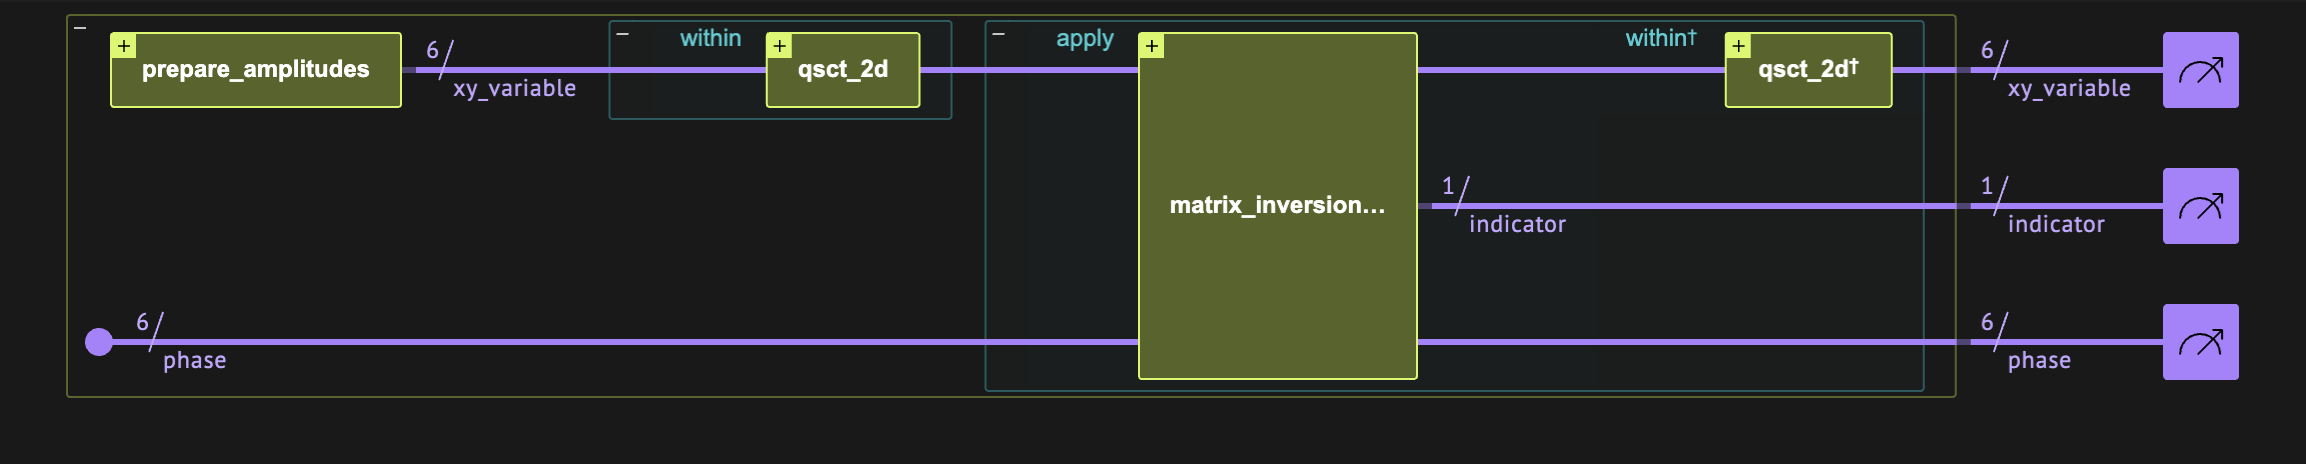
<center>
<figcaption align = "middle"> Figure 2. The quantum circuit for solving the Poisson equation. </figcaption>

Below we define several classical and quantum functions for constructing our quantum linear solver.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy

from classiq import *

### Diagonal Hamiltonian Calculation

The eigenvalues of the Poisson equation with Dirichlet boundary conditions in the x direction and Neumann boundary conditions in the y direction are given by
$$
\lambda_{k,j} \equiv \lambda_{x,k} +\lambda_{y,j}
$$
where
$$
\lambda_{x,k} = \frac{4}{\Delta x^2} \sin^2\left(\frac{\pi}{2N_x} (k+1)\right),\,\,\,\,\,\,\,\,
\lambda_{y,j} = \frac{4}{\Delta y^2} \sin^2\left(\frac{\pi}{2N_y} j\right),
$$
and $k = 0, 1, \ldots, N_y-1$ and $j = 0, 1, \ldots, N_x-1$.

The HHL algorithm requires the application of an Hamiltonian simulation $e^{iH}$. In this notebook this quantum block is implemented using the Suzuki-Trotter built-in function. We start with defining a function that gets $N_x$ and $N_y$ and returns the corresponding Hamiltonian. The decomposition of the diagonal matrix to the Pauli basis is done using the Walsh Hadamard transform.

In [2]:
def get_poisson_dirichletx_neumanny_ham(nx, ny):
    dx2 = ny / nx
    dy2 = nx / ny
    eigenvalues_x = dx2 * 4 * np.sin(np.pi / 2 * np.arange(1, nx + 1) / nx) ** 2
    eigenvalues_y = dy2 * 4 * np.sin(np.pi / 2 * np.arange(0, ny) / ny) ** 2
    num_qubits_x = int(np.log2(nx))
    num_qubits_y = int(np.log2(ny))

    # Decompose the eigenvalues of the Poisson equation into Pauli terms and construct the corresponding Hamiltonian
    pauli_coefficients_x = sympy.fwht(eigenvalues_x / nx)
    pauli_coefficients_y = sympy.fwht(eigenvalues_y / ny)

    def convert_bitstring_to_pauli_representation(
        bitstring: int, num_qubits: int
    ) -> list[Pauli]:
        return [
            Pauli.Z if (bitstring >> s) & 1 else Pauli.I for s in range(num_qubits)
        ][::-1]

    hamiltonian_y = [
        PauliTerm(
            pauli=convert_bitstring_to_pauli_representation(i, num_qubits_y)
            + [Pauli.I] * num_qubits_x,
            coefficient=pauli_coefficients_y[i],
        )
        for i in range(ny)
    ]
    hamiltonian_x = [
        PauliTerm(
            pauli=[Pauli.I] * num_qubits_y
            + convert_bitstring_to_pauli_representation(i, num_qubits_x),
            coefficient=pauli_coefficients_x[i],
        )
        for i in range(nx)
    ]

    hamiltonian = hamiltonian_x + hamiltonian_y
    return hamiltonian

### Hamiltonian Evolution for QPE

The HHL is based on a [QPE](https://github.com/Classiq/classiq-library/blob/main/tutorials/advanced_tutorials/high_level_modeling_flexible_qpe/high_level_modeling_flexible_qpe.ipynb) applied on $e^{iHt}$. For this, we need to define a function implementing $\left(e^{iHt}\right)^p$ for an integer power $p$. Since in our case the Hamiltonian is diagonal, an exact implementation is given by the first order Suzuki-Trotter formula, where in addition $\left(e^{iHt}\right)^p = e^{ipHt}$.

In [3]:
@qfunc
def powered_hamiltonian_evolution(
    hamiltonian: CArray[PauliTerm],  # the hamiltonian H
    scaling: CReal,  # the scaling factor t
    p: CInt,  # the power
    qba: QArray,
):
    suzuki_trotter(
        pauli_operator=hamiltonian,
        evolution_coefficient=p * (-2 * np.pi * scaling),
        order=1,
        repetitions=1,
        qbv=qba,
    )

### Sine and Cosine Transforms

For the system treated in this notebook, diagonalization of the $2D$ Laplacian is given by appying a quantum sine (cosine) transform on the $x$ ($y$) dimension. We define a quantum function for implementing this, using the open library functions:

In [4]:
@qfunc
def qsct_2d(xy_variable: QArray[QNum, 2]):
    qst_type2(xy_variable[0])
    qct_type2(xy_variable[1])

### Matrix Inversion

Finally, we define a matrix inversion using a QPE routine, similar to the example given in the basic [HHL notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb).

In [5]:
@qfunc
def matrix_inversion_HHL(
    prefactor: CReal,
    my_unitary: QCallable[CInt, QArray],
    state: QArray,
    phase: QNum,
    indicator: Output[QBit],
):
    allocate(indicator)

    within_apply(
        within=lambda: qpe_flexible(
            unitary_with_power=lambda power: my_unitary(power, state),
            phase=phase,
        ),
        apply=lambda: assign_amplitude(prefactor / phase, indicator),
    )

## Example: Non-separable Source Term

We solve an example with a square grid of $N_x,\, N_y=2^3$. For the source term we take a non-separable $2^{N_x+N_y}$ vector that represents the function
$$
b = F\left[xy(x-L_x)(y-L_y)\right].
$$
We choose $F(z)=\tanh(z)^2$, which satisfies the boundary conditions.

In [6]:
# Set discretization of X and Y axes.
NUM_QUBITS_X = 3
NUM_QUBITS_Y = 3
nx = 2**NUM_QUBITS_X
ny = 2**NUM_QUBITS_Y

# Set the source term as function of x and y such that b(x,y) = exp(-1/xy(x-Lx)(y-Ly))
xgrid = (np.arange(nx) + 0.5) / nx
ygrid = (np.arange(ny) + 0.5) / ny
zgrid = np.kron(ygrid, xgrid) * np.kron(
    (ygrid - 1), (xgrid - 1)
)  # in classiq the variable order is [y,x]
b_vector = np.tanh(zgrid) ** 2

# Normalize the source term
b_vector = b_vector / np.linalg.norm(b_vector)

We can plot the source term:

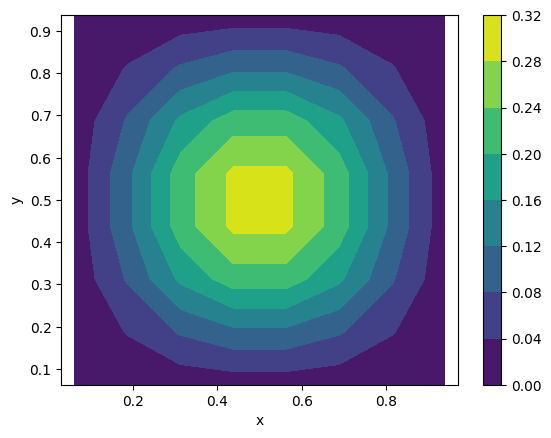

In [7]:
b_matrix = b_vector.reshape((nx, ny))
xmesh, ymesh = np.meshgrid(xgrid, ygrid)
plt.contourf(xmesh, ymesh, b_matrix.transpose())
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
ax.axis("equal")
plt.colorbar()
plt.show()

Next, we calculate the Hamiltonian for the specific discretization: 

In [8]:
hamiltonian = get_poisson_dirichletx_neumanny_ham(nx, ny)

Now, we need to define the resolution (QPE size) for the quantum solver. The required number of QPE phase qubits depends on the condition number $\kappa$ of the inverted matrix. In the case of the Laplacian matrix, this parameter is of the order of the matrix dimension $O(2^{N_x+N_y})$, which eliminates the exponential advantage. However, in our example we have a smooth source term, and high modes are expected to have minor effects on the solution. The highest mode of $\mathcal{L}$ is $\lambda_{\max}=8$, whereas the smallest one is $\lambda_{x,0}\sim 4\pi^2/(2N_x)^2$. Let us assume that the highest mode participating in the solution is $\sim 2^6 \lambda_{x,0}$, and take a QPE size of six qubits.

In [9]:
# number of qubits for the QPE
QPE_SIZE = 6
MAX_EIG = 4 * (np.pi / (2 * nx)) ** 2 * 2**6
# parameters for the amplitude preparation
PREFACTOR = 2**-QPE_SIZE

We build the model and synthesize it:

*Comment: the model is designed for the case of symmetric grid $N_x=N_y$, working with `QArray[QNum,2]`. In the more general case one can define a `QStruct` with two `QNum` variable of different sizes*

In [10]:
@qfunc
def main(
    xy_variable: Output[QArray[QNum[NUM_QUBITS_X], 2]],
    phase_var: Output[QNum[QPE_SIZE]],
    indicator: Output[QBit],
):

    prepare_amplitudes(b_vector.tolist(), 0.0, xy_variable)
    allocate(phase_var)

    within_apply(
        within=lambda: qsct_2d(xy_variable),
        apply=lambda: matrix_inversion_HHL(
            prefactor=PREFACTOR,
            my_unitary=lambda p, target: powered_hamiltonian_evolution(
                hamiltonian=hamiltonian,
                scaling=1 / MAX_EIG,
                p=p,
                qba=target,
            ),
            state=xy_variable,
            phase=phase_var,
            indicator=indicator,
        ),
    )


qmod = create_model(main, constraints=Constraints(max_width=18))
write_qmod(qmod, "discrete_poisson_solver", decimal_precision=12)
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/32pZbY4ZtlxYiymOopvtvjloFFz


### Executing and Plotting the Result

We run the quantum program on a statevector simulator to retrieve the full solution.

In [11]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionDetails,
    ExecutionPreferences,
    set_quantum_program_execution_preferences,
)

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator_statevector")
)
qprog = set_quantum_program_execution_preferences(qprog, execution_preferences)
result = execute(qprog).result_value()

In [12]:
import pandas as pd


# Retrieve the solution of the Poisson equation from the results of the quantum program.
def extract_result_from_statevector_simulation(
    df: pd.DataFrame,
    normalization: float,
    indicator_name: str,
    phase_name: str,
    xy_name: str,
) -> np.ndarray:

    # Initialize a matrix
    state_matrix = np.zeros((nx, ny), dtype=complex)

    # Filter only the successful states.
    filtered_st = df[
        (df[indicator_name] == 1)
        & (df[phase_name] == 0)
        & (np.abs(df.amplitude) > 1e-12)
    ]

    # Allocate values
    state_matrix[tuple(np.array(filtered_st[xy_name].tolist()).T)] = (
        filtered_st.amplitude.to_numpy()
    )

    # Normalize the solution of the Poisson equation.
    global_phase = np.angle(state_matrix[0, 0])
    result_matrix = np.real(state_matrix / np.exp(1j * global_phase)) / normalization

    return result_matrix

In [13]:
result_matrix = extract_result_from_statevector_simulation(
    result.dataframe, PREFACTOR / MAX_EIG, "indicator", "phase_var", "xy_variable"
)

The resulting statevector is given up to a sign. The sign in the center of the solution is expected to be positive. We can correct accordingly:

In [14]:
if result_matrix[nx // 2, ny // 2] < 0:
    result_matrix = -result_matrix

Finally, we print the result and compare it to the classical solution:

In [15]:
## getting the classical solution
Hx = (
    2 * np.diag(np.ones(nx))
    - np.diag(np.ones(nx - 1), 1)
    - np.diag(np.ones(nx - 1), -1)
)
Hx[0, 0] = Hx[nx - 1, nx - 1] = 3

Hy = (
    2 * np.diag(np.ones(ny))
    - np.diag(np.ones(ny - 1), 1)
    - np.diag(np.ones(ny - 1), -1)
)
Hy[0, 0] = Hy[ny - 1, ny - 1] = 1

# we need to flip the order of x and y
b_classical = (b_matrix.T).reshape(nx * ny)

H = np.kron(Hx, np.identity(ny)) + np.kron(np.identity(nx), Hy)
classical_result_vector = np.linalg.solve(H, b_classical)
classical_result_matrix = classical_result_vector.reshape((nx, ny))

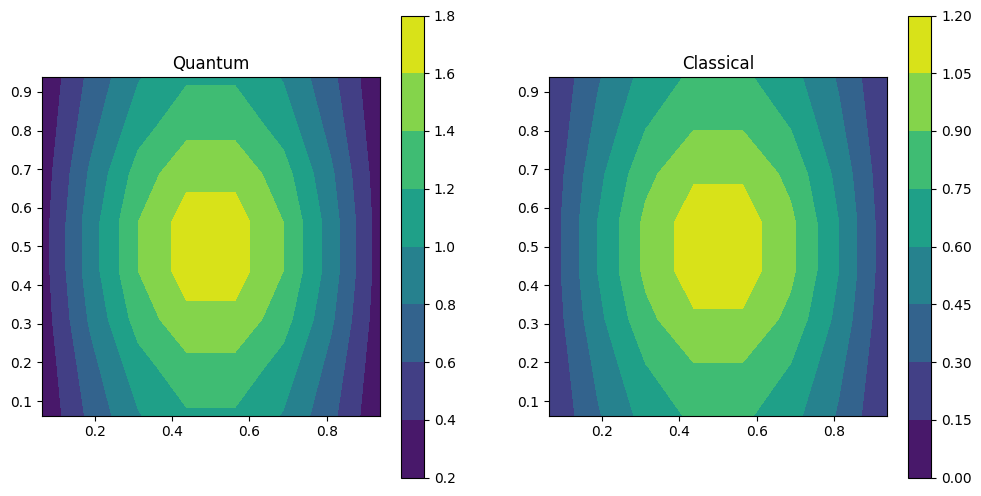

In [16]:
xmesh, ymesh = np.meshgrid(xgrid, ygrid)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
contour0 = axs[0].contourf(xmesh, ymesh, result_matrix.transpose())
axs[0].axis("equal")
axs[0].axis("square")
axs[0].title.set_text("Quantum")
fig.colorbar(contour0, ax=axs[0])

contour1 = axs[1].contourf(xmesh, ymesh, classical_result_matrix.transpose())
axs[1].axis("equal")
axs[1].axis("square")
axs[1].title.set_text("Classical")
fig.colorbar(contour1, ax=axs[1])

plt.show()

## References

<a id='CST'>[1]</a>: [Strang, G., 1999 SIAM Review 41 135. The discrete cosine transform.](https://doi.org/10.1137/S0036144598336745)

<a id='PoissonQuantum'>[2]</a>: [Yudong Cao et al., 2013 New J. Phys. 15 013021. Quantum algorithm and circuit design solving the Poisson equation.](https://iopscience.iop.org/article/10.1088/1367-2630/15/1/013021/pdf)

<a id='QCST'>[3]</a>: [Klappenecker, A., & Rotteler M., Discrete cosine transforms on quantum computers.](https://arxiv.org/abs/quant-ph/0111038)
